In [1]:
from IPython import get_ipython
from IPython.display import display
import os
from glob import glob
import torch
import monai
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from monai.transforms import (
    Compose, LoadImage, EnsureChannelFirst, ScaleIntensity, Resize, ToTensor
)
from monai.data import Dataset, DataLoader
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from torch.optim import Adam
from monai.transforms import AsDiscrete
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transforms = Compose([
    LoadImage(image_only=True, reader ="NibabelReader"),
    EnsureChannelFirst(),
    ScaleIntensity(),
    Resize((128, 128, 128)),
    ToTensor()
])


In [17]:
# data_dir = "data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
data_dir = "C:/Users/ok/Documents/project/new/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

def load_data():
  images= []
  for root, _, files in os.walk(data_dir):
    for file in files:
      if file.endswith("nii"):
        images.append(os.path.join(root,file))
  print(f"number of images found: {len(images)}")
  return Dataset(data=images, transform=transforms)

# def load_data():
#   # Use glob to find all .nii files recursively
#   image_paths = glob(os.path.join(data_dir, '**/*.nii'), recursive=True)
#   print(f"number of images found using glob: {len(image_paths)}")
#   return Dataset(data=image_paths, transform=transforms)



dataset = load_data()
train_paths, val_paths = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_paths, batch_size = 4, shuffle = True)
val_loader = DataLoader(val_paths, batch_size = 4, shuffle = True)

number of images found: 250


In [18]:
model = UNet(
    spatial_dims =3,
    in_channels =1,
    out_channels =1,
    channels =(16, 32, 64, 128, 256),
    strides =(2, 2, 2, 2),
    num_res_units =2
).to(device)

In [19]:
loss_function = DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [13]:
def compute_accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.numel()
    return correct / total

In [20]:
def train(num_epochs=6):
  model.train()
  for epoch in range(num_epochs):
    epoch_loss = 0
    for batch in train_loader:
      inputs = batch.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_function(outputs, inputs)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      # acc = compute_accuracy(outputs, labels)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


In [21]:
train()

Epoch 1/6, Loss: 44.0294
Epoch 2/6, Loss: 43.3804
Epoch 3/6, Loss: 43.1769
Epoch 4/6, Loss: 43.0466
Epoch 5/6, Loss: 42.9451
Epoch 6/6, Loss: 42.8559


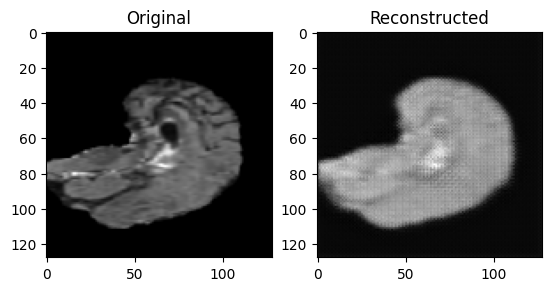

In [22]:

model.eval()
with torch.no_grad():
  for sample in val_loader:
    sample = sample.to(device)
    output = model(sample)

  # Move to CPU and convert to NumPy for plotting
  sample_np = sample.cpu().numpy()
  output_np = output.cpu().numpy()

  plt.subplot(1,2,1)
  # Select the first sample, first channel, and a depth slice
  plt.imshow(sample_np[0, 0, sample_np.shape[2]//2, :, :], cmap='gray')
  plt.title("Original")

  plt.subplot(1, 2, 2)
  # Select the first sample, first channel, and a depth slice for the output
  plt.imshow(output_np[0, 0, output_np.shape[2]//2, :, :], cmap='gray')
  plt.title("Reconstructed")
  plt.show()
